In [1]:
import pandas as pd
import numpy as np
import requests
import bs4
import pandas as pd
from bs4 import BeautifulSoup
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium import webdriver
import datetime
import urllib
import statsmodels.api as sm
from sklearn import linear_model
import sklearn
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
% matplotlib inline
lm = linear_model.LinearRegression()
LR=sklearn.linear_model.LogisticRegression
LRCV=sklearn.linear_model.LogisticRegressionCV

ImportError: No module named phantomjs.webdriver

In [65]:
import pandas as pd
import numpy as np

#Cleans up the Stock information
nyse=pd.read_csv("Data/NYSE.csv")
nasdaq=pd.read_csv("Data/NASDAQ.csv")
amex=pd.read_csv("Data/AMEX.csv")
stocks=nyse.append(nasdaq,ignore_index=True).append(amex,ignore_index=True)
del stocks["Summary Quote"]
i=0
while i<len(stocks["Symbol"]):
    if " (The)" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" (The)")]
    if " Incorporated" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Incorporated")]
    if ", Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc.")]
    if ", Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if ", INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(", Inc")]
    if " Inc." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc.")]
    if " Inc" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if " INC" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Inc")]
    if  " Corporation" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corporation")]
    if " Corp." in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp.")]
    if " Corp" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    if " CORP" in stocks.iloc[i,1]:
        stocks.iloc[i,1]=stocks.iloc[i,1][:len(stocks.iloc[i,1])-len(" Corp")]
    i+=1

#Eliminates Duplicates, inactive tickers, and funds
#For MarketCap n/a; the tickers listed had 1 market value and all other duplicates were n/a; safe to remove
#Additionally, there was the occasional case of no market cap; market cap must have been insignificant or bankrupt
#stocks= stocks[stocks['MarketCap']!="n/a"]
#stocks= stocks[stocks['industry']!="n/a"]
#stocks= stocks[stocks['Sector']!="n/a"]
#stocks= stocks[stocks['IPOyear']!="n/a"]

#Convert MarketCap to Millions of dollars
i=0
while i<len(stocks["MarketCap"]):
    if "B" in str(stocks.iloc[i,3])[-1:]:
        stocks.iloc[i,3]=float(str(stocks.iloc[i,3])[1:-1])*1000
    else:
        stocks.iloc[i,3]=str(stocks.iloc[i,3])[1:-1]
    i+=1

stocks=stocks.reset_index()
del stocks['index']
#delete={1572:'WYIGU',1001:'ANDAU',873:'FNFV',1322:'ELECU',1376:'FCFS',1134:'CLACU',2041:'TRTLU',1706:'MSG'}
# keys=delete.keys()
# keys.sort()
# keys=keys[::-1]
# for key in keys:
#     stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
# stocks=stocks.reset_index()
# del stocks['index']

#Cleans cities data (eliminates counties and combined cities/towns)
cities=pd.read_csv("Data/Living_Index.csv")
cities=cities.rename(columns={"Urban Area":"City"})
values=[]
for x in cities["City"]:
    if "-" in x:
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
values=[]
for x in cities["City"]:
    if "county" in x.lower():
        values.append(False)
    else:
        values.append(True)
cities=cities[values]
new_city_list=[]

for x in cities["City"]:
    y=x[-4:]
    z=x[:-len(y)].replace(",","")+y
    new_city_list.append(z)
cities["City"]=new_city_list

In [66]:
#Put ticker of name instances into a dictionary for all duplicates

#Gives the duplicates in a list called names
names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]
indices=[]
index=[]
dic={}
i=0
while i < len(stocks["Name"]):
    if stocks.loc[i,"Name"] in names:
        if stocks.loc[i,"Name"] in dic.keys():
            dic[stocks.loc[i,"Name"]].append([stocks.loc[i,"Symbol"],stocks.loc[i,"MarketCap"]])
        else:
            dic[stocks.loc[i,"Name"]]=[[stocks.loc[i,"Symbol"],stocks.loc[i,"MarketCap"]]]
    i+=1

#Look up to see if there is a single entry with a market cap for the duplicates; if there is, delete others

#Checks to see if among duplicate entries there is only a single one with market cap
caps=[]
for key in dic.keys():
    l=dic[key]
    single_cap=False
    num_caps=0
    for x in l:
        if x[1]!="/":
            num_caps+=1
        if num_caps==1:
            single_cap=True
        else: 
            single_cap=False
    caps.append([key,single_cap])

#Finds tickers without market cap to delete
delete=[]
for x in caps:
    if x[1]==True:
            #If there is a single market cap value, deletes all others
        for y in dic[x[0]]:
            if y[1]=="/":
                delete.append(y[0])
    if x[1]==False:
            #Checks to see if there are duplicate market cap values; if there are, resorts to largest
        mult=False
        count=0
        for y in dic[x[0]]:
            if y[1]!="/":
                count+=1
            if count>1:
                mult=True
        largest=0
        save_ticker=""
        if mult:
            for y in dic[x[0]]:
                if y[1]!="/":
                    if y[1]>largest:
                        largest=y[1]
                        save_ticker=y[0]
            for z in dic[x[0]]:
                if z[0]!=save_ticker:
                    delete.append(z[0])
            #If there are no market cap values, resorts to shortest ticker name
        else:
            save_ticker=""
            length=10
            for y in dic[x[0]]:
                if len(y[0])<length:
                    save_ticker=y[1]
            for z in dic[x[0]]:
                if z[0]!=save_ticker:
                    delete.append(z[0])

#NOW, time to go through and delete the unneeded rows; 
    #reset the index, get the indices, reverse order the sort,
    #and reset the dataframe on each value; then reset index

indices=[]
i=0
while i<len(stocks):
    if stocks.loc[i,"Symbol"] in delete:
        indices.append(i)
    i+=1
indices.sort()
indices=indices[::-1]
for key in indices:
    stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
stocks=stocks.reset_index()
del stocks['index']

#There is only one case left; where there are duplicate entries; let's delete those now
names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]
delete=[]

for name in names:
    first=True
    i=0
    while i<len(stocks["Name"]):
        if first:
            first=False
        if stocks.loc[i,"Name"]==name:
            delete.append(i)
        i+=1
delete.sort()
delete=delete[::-1]
for key in delete:
    stocks=stocks.iloc[:key].append(stocks.iloc[key+1:])
stocks=stocks.reset_index()
del stocks['index']

In [63]:
names=[x for x,y in zip(stocks["Name"].value_counts().sort_values(ascending=False).index,\
                        stocks["Name"].value_counts().sort_values(ascending=False).values) if y>1]


# [x for x in stocks["Name"] if x[0:3]=="Mat"] #-->Additional Search Method; looks for first three letters

#Finds all instances of a company name within stocks["Name"], and prints the instance and its index numer
for name in names:
    i=0
    while i<len(stocks):
        if stocks.loc[i,"Name"]==name:
            print "index: ",i
            print stocks.iloc[i]
            print "\n"
        i+=1
# top=stocks.index
# keep=[]
# for x in top:
#     if x not in del_indices:
#         keep.append(x)
# len(keep)

In [64]:
[x for x in stocks["Name"] if x[0:7]=="Lockhee"] #-->Additional Search Method; looks for first three letters

['Lockheed Martin']

In [75]:
#Takes in json of webscraped information, puts it into a dataframe, converts Salary information to integers
glass_door=pd.DataFrame(columns=["Salary","Company","Location"])

extension="Data/allcities.json"
json=pd.read_json(extension)
json2=json.copy()
del json["jobTitle"]
l=[]
i=0
j=0
while i< len(json):
    j=0
    while j< len(json.iloc[i]):
        if type(json.iloc[i,j])==dict:
            l.append(json.iloc[i,j])
        j+=1
    i+=1
#for x in new_city_list:
salary=[x["meanPay"] for x in l]
company=[x["company"] for x in l]
location=[x["city"] for x in l]
df=pd.DataFrame([salary,company,location]).T
df.columns=["Salary","Company","Location"]
temp=[]
for x in df["Salary"]:
    if x[3]==" ":
        temp.append(np.nan)
    elif x[-1]=='k':
        num1=0
        num2=0
        if x[3]=="k":
            num1=int(x[1:3])
        if x[4]=="k":
            num1=int(x[1:4])
        if x[-4]=="$":
            num2=int(x[-3:-1])
        if x[-5]=="$":
            num2=int(x[-4:-1])
        temp.append((num1+num2)*500) #Same as *1000(sal.1+sal.2)/2
    else:
        temp.append(x)
temp2=[]
for x in temp:
    if str(x)[0]=="$":
        temp2.append(str(x)[1:].replace(",",""))
    else:
        temp2.append(x)
df['Salary']=temp2
df=df[pd.notnull(df["Salary"])].reset_index()
del df['index']
df["Salary"]=df['Salary'].astype(np.int)

glass_door=glass_door.append(df,ignore_index=True)

In [76]:
df=pd.merge(glass_door,cities,left_on="Location",right_on="City")
df=pd.merge(df,stocks,left_on="Company",right_on="Name")
print len(glass_door),len(df)
df['Salary']=df['Salary'].astype(np.int)
df.columns

0 0


Index([u'Company', u'Location', u'Salary', u'City', u'100% Composite Index',
       u'13 % Grocery Items', u'29 % Housing', u'10% Utilities',
       u'12 % Transportation', u'4% Health Care',
       u'32 % Miscellaneous Goods and Services', u'Symbol', u'Name',
       u'LastSale', u'MarketCap', u'IPOyear', u'Sector', u'industry'],
      dtype='object')

In [497]:
cols=[ '13 % Grocery Items', '29 % Housing', u'10% Utilities',
       '12 % Transportation', '4% Health Care',
       '32 % Miscellaneous Goods and Services']

In [13]:
print 170/731.
print 258/731.

0.232558139535
0.352941176471


In [74]:
json

,city,company,meanPay
0,"Albany, NY",GE,$100k - $108k
1,"Arlington, TX",State Farm,$100k - $110k
2,"Arlington, TX",Epsilon,$160k - $173k
3,"Arlington, TX",Match,$79k - $86k
4,"Arlington, TX",Hudl,$86k - $94k
5,"Arlington, TX",AT&T,$92k - $101k
6,"Arlington, TX",IBM,$102k - $113k
7,"Arlington, TX",Capital One,$104k - $114k
8,"Arlington, TX",PwC,$96k - $104k
9,"Arlington, TX",KPMG,$90k - $98k


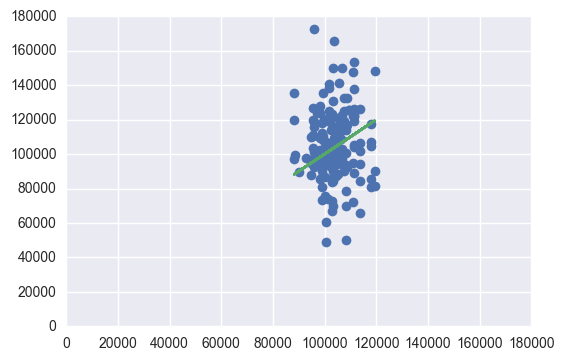

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.963     
Dependent Variable: Salary           AIC:                12427.2246
Date:               2016-10-16 17:29 BIC:                12453.0623
No. Observations:   548              Log-Likelihood:     -6207.6   
Df Model:           6                F-statistic:        2409.     
Df Residuals:       542              Prob (F-statistic): 0.00      
R-squared:          0.964            Scale:              4.0877e+08
---------------------------------------------------------------------
         Coef.     Std.Err.      t      P>|t|      [0.025     0.975] 
---------------------------------------------------------------------
x1     -183.0422   128.5446   -1.4240   0.1550   -435.5488    69.4644
x2      -73.0979    19.1275   -3.8216   0.0001   -110.6709   -35.5248
x3      -33.8422    55.9067   -0.6053   0.5452   -143.6625    75.9780
x4      560.4425   132.0235    4.2450   0.0000    301.

In [527]:
xtr,xte,ytr,yte=train_test_split(df[cols],df['Salary'])
xtr=np.array(xtr).reshape(len(xtr),6)
xte=np.array(xte).reshape(len(xte),6)
xtr2=sm.add_constant(xtr)
model=sm.OLS(ytr,xtr).fit()

xte2=sm.add_constant(xte)
pred=model.predict(xte)

plt.plot(pred,yte,'o')
plt.plot(pred,pred,'-')
plt.xlim(0,180000)
plt.ylim(0,180000)
plt.show()

print model.summary2()

In [528]:
temp=xtr[:len(xtr)/3]
plt.hist(xte["100% Composite Index"],bins=5)
plt.hist(temp["100% Composite Index"],bins=5)
plt.show()

/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [416]:
df.iloc[730]

Salary                                           138500
Company                                     Capital One
Location                                 Wilmington, DE
City                                     Wilmington, DE
100% Composite Index                              105.2
13 % Grocery Items                                108.1
29 % Housing                                        102
10% Utilities                                     115.4
12 % Transportation                                98.6
4% Health Care                                    108.7
32 % Miscellaneous Goods and Services             105.2
Name: 730, dtype: object

For the logistic regressions, make the discrete value a bin; the smallest bin will be 0. The goal should be to make the bins be organized so that a linear plot can be drawn through them. If the linear plot does not run through them, then there is significant risk of misidentifying a bin. Depending on what the x-axis is (most-likely score), the bins will have to have an equal width along this x-axis (i.e., all bins having a width of x-units on the x-axis).

Contrarily, we want evenly distributed bins in the price aspect.

So, if one were to not do a multinomial logistic regression, one could additionally do a series of logistic regressions. One would check to see if the point goes into bin 0 or 1. If it goes into 1, one would check to see if it goes into bins 1 or 2. If it is in bin 2, one would see if it goes into bins 2 or 3... If it does not go into the higher bin, the regression sequence ends, and the point enters the lower of the two bins.
### Scratch ^; essentially a multinomial logistic regression

In [146]:
#Merge Company Data and Location Data